In [1]:
#import config  # Import your config.py file this contains you openai api key
import pandas as pd
import numpy as np
import os
from llm_comparison_toolkit import RateLimiter, get_response_openai, get_response_anthropic,  create_config_dict_func, use_df_to_call_llm_api, compare_request_configurations
from evaluate import load
from evaluation_funcs import load_txt_files_to_df, evaluate_ocr_dataframe, evaluate_correction_performance, evaluate_correction_performance_folders, get_metric_error_reduction
import seaborn as sns
import matplotlib.pyplot as plt

dev_transcripts = 'data/dev_data_transcript'

#load the dev and test sets for prompt development and selection
dev_data_df = pd.read_csv('data/dev_data_raw.csv')
test_data_df = pd.read_csv('data/test_data_raw.csv')

/home/jonno/redigitalize/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Explore different system prompts

This explores a range of system prompt to find the one that appears to work the best, we use gpt4 as the baseline model.

Although there is no comparison with all models we do test gpt3.5 and Mixtral, just as a sanity check that the prompts may react differently on different models

In [2]:
#Create a modular set of system messages that can be combined in different ways
basic_prompt = "Please recover the text from the corrupted OCR."
expertise_prompt = "You are an expert in post-OCR correction of documents."
recover_prompt = "Using the context available from the text please recover the most likely original text from the corrupted OCR."
publication_context_prompt = "The text is from an english newspaper in the 1800's."
text_context_prompt = "The text may be an advert or article and may be missing the beggining or end."
additional_instructions_prompt = "Do not add any text, commentary, or lead in sentences beyond the recovered text. Do not add a title, or any introductions."

#combine all the message parts into a variety of system messages, a tuple is used where 0 is the name of the message and 1 is the message itself
#N.B. This is not and exhaustive combination as that would be very expensive and likley not yield significantly better results
system_messages_list = [
('basic_prompt', basic_prompt),
('expert_basic_prompt', expertise_prompt + ' '+ basic_prompt),
('expert_recover_prompt', expertise_prompt + ' '+ recover_prompt),
('expert_recover_publication_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt),
('expert_recover_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + text_context_prompt),
('expert_recover_publication_text_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt),
('expert_recover_instructions_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + additional_instructions_prompt),
('full_context_prompt', expertise_prompt + ' '+ recover_prompt + ' ' + publication_context_prompt + ' ' + text_context_prompt+ ' ' + additional_instructions_prompt)
]

In [ ]:
def create_message_test_configs(system_messages_list, get_response_func, engine):
    message_test_configs = []
    for iter_system_message in system_messages_list:
        message_test_configs.append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template=iter_system_message[1],
                prompt_template="{content_html}",
                additional_args={'response_name': iter_system_message[0]}
            )
        ).append(
            create_config_dict_func(
                get_response_func=get_response_func,
                rate_limiter=RateLimiter(50000),
                engine=engine,
                system_message_template="",
                prompt_template="{content_html}" + f"""\n\n""" + iter_system_message[1],
                additional_args={'response_name': iter_system_message[0]}
            )
        )
    return message_test_configs

## GPT3 prompt tests

In [32]:
#Loop through all the system messages and generate a config dictionary for each one
message_test_configs = []

for iter_system_message in system_messages_list:

    message_test_configs.append(
        
        create_config_dict_func(
        get_response_func = get_response_openai,
        rate_limiter = RateLimiter(50000),
        engine = "gpt-3.5-turbo",
        system_message_template = iter_system_message[1], # element 1 is the message itself
        prompt_template =  "{content_html}",
        additional_args={'response_name':iter_system_message[0]} #element 0 is the name of the message
    )
    ).append(

        create_config_dict_func(
        get_response_func = get_response_openai,
        rate_limiter = RateLimiter(50000),
        engine = "gpt-3.5-turbo",
        system_message_template = "",
        prompt_template = "{content_html}" + f"""\n\n""" + iter_system_message[1],
        additional_args={'response_name':iter_system_message[0]}
    )

    ) 

#Run on both the dev and test sets.

compare_request_configurations(dev_data_df, message_test_configs, folder_path='./data/dev_system_message_variants')

#compare_request_configurations(test_data_df, message_test_configs, folder_path='./data/test_system_message_variants')

In [ ]:
#gpt configs
gpt3_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, "gpt-3.5-turbo")
gpt4_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_openai, 'gpt-4-turbo-preview')

#claude configs
haiku_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-haiku-20240307")
opus_prompt_testing_configs = create_message_test_configs(system_messages_list, get_response_anthropic, "claude-3-opus-20240229")

#run the experiment on all the prompt configs and save to the folder
compare_request_configurations(dev_data_df, 
                               gpt3_prompt_testing_configs + gpt4_prompt_testing_configs + haiku_prompt_testing_configs + opus_prompt_testing_configs
                               folder_path='./data/dev_system_message_variants')

## Haiku test

Test the prompts on claude 3 Haiku

In [34]:
message_test_configs = []

for iter_system_message in system_messages_list:

    message_test_configs.append(
        
        create_config_dict_func(
        get_response_func = get_response_anthropic,
        rate_limiter = RateLimiter(50000),
        engine = "claude-3-haiku-20240307",
        system_message_template = iter_system_message[1],
        prompt_template =  "{content_html}",
        additional_args={'response_name':iter_system_message[0]}
    )
    ).append(

        create_config_dict_func(
        get_response_func = get_response_anthropic,
        rate_limiter = RateLimiter(50000),
        engine = "claude-3-haiku-20240307",
        system_message_template = "",
        prompt_template = "{content_html}" + f"""\n\n""" + iter_system_message[1],
        additional_args={'response_name':iter_system_message[0]}
    )

    )

#Run on both the dev and test sets.

compare_request_configurations(dev_data_df, message_test_configs, folder_path='./data/dev_system_message_variants')

#compare_request_configurations(test_data_df, message_test_configs, folder_path='./data/test_system_message_variants')

Rate limit error: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your rate limit (https://docs.anthropic.com/claude/reference/rate-limits). Please reduce the the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}
Pausing for 60 seconds before retrying...
Failed to get model response after multiple attempts.
Rate limit error: Error code: 429 - {'type': 'error', 'error': {'type': 'rate_limit_error', 'message': 'Number of request tokens has exceeded your rate limit (https://docs.anthropic.com/claude/reference/rate-limits). Please reduce the the prompt length or the maximum tokens requested, or try again later. You may also contact sales at https://www.anthropic.com/contact-sales to discuss your options for a rate limit increase.'}}
Pausing for 60 seconds before retrying...
Fa

KeyboardInterrupt: 

## Evaluate system prompt tests

We evaluate the system prompts below to see if thre is any significant difference between the prompts


In [35]:
wer = load("wer")
cer = load("cer")

In [36]:
raw_dev_ocr_scores = evaluate_correction_performance('data/dev_raw_ocr', dev_transcripts, wer, cer, 'raw_ocr')

In [45]:
corrected_folder = './data/dev_system_message_variants'

performance_eval = evaluate_correction_performance_folders(corrected_folder, dev_transcripts, wer, cer)

performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt'),:]

performance_eval['type'] = performance_eval['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")

In [46]:
test = get_metric_error_reduction(performance_eval, raw_dev_ocr_scores)

In [47]:
test.groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER            CER  \
                                                     mean    50%    mean   
type                                                                       
expert_recover_text_prompt_haiku                    -3.36  13.64 -296.74   
expert_recover_publication_text_prompt_haiku        17.73  35.45 -209.70   
expert_recover_prompt_haiku                         39.84  48.11  -90.64   
expert_recover_publication_prompt_haiku             47.73  51.82  -61.89   
basic_prompt_haiku                                  62.94  65.52   18.34   
expert_basic_prompt_haiku                           63.31  67.80   22.17   
full_context_prompt_haiku                           40.18  62.37  -29.16   
expert_recover_text_prompt_gpt-3.5-turbo            53.33  67.92   -1.76   
expert_recover_instructions_prompt_haiku            53.39  65.28   -9.79   
basic_prompt_gpt-3.5-turbo                         -17.01  71.22 -307.78   
full_context_prompt_gpt-3.5-turbo                   63.07  72.66   46.24   
expert_basic_prompt_gpt-3.5-turbo                   64.78  69.06   49.76   
expert_recover_instructions_prompt_gpt-3.5-turbo    63.34  68.82   49.00   
expert_recover_prompt_gpt-3.5-turbo                 66.25  73.12   33.28   
expert_recover_publication_prompt_gpt-3.5-turbo     68.99  76.02   51.48   
expert_recover_publication_text_prompt_gpt-3.5-...  69.37  75.44   53.30   

                                                           lev_dist          
                                                       50%     mean     50%  
type                                                                         
expert_recover_text_prompt_haiku                   -197.56  -282.00 -177.78  
expert_recover_publication_text_prompt_haiku       -115.22  -198.48 -110.20  
expert_recover_prompt_haiku                         -39.82   -85.44  -36.21  
expert_recover_publication_prompt_haiku               6.28   -58.81   10.00  
basic_prompt_haiku                                   28.05    18.47   23.33  
expert_basic_prompt_haiku                            24.89    22.06   25.29  
full_context_prompt_haiku                            34.46   -28.69   34.11  
expert_recover_text_prompt_gpt-3.5-turbo             43.07    -2.03   42.03  
expert_recover_instructions_prompt_haiku             44.52    -9.06   44.47  
basic_prompt_gpt-3.5-turbo                           49.40  -291.36   45.50  
full_context_prompt_gpt-3.5-turbo                    47.94    43.45   46.74  
expert_basic_prompt_gpt-3.5-turbo                    50.00    46.75   48.07  
expert_recover_instructions_prompt_gpt-3.5-turbo     50.44    45.93   48.50  
expert_recover_prompt_gpt-3.5-turbo                  50.88    31.16   48.64  
expert_recover_publication_prompt_gpt-3.5-turbo      55.56    48.25   50.00  
expert_recover_publication_text_prompt_gpt-3.5-...   55.13    50.00   50.91

In [48]:
performance_eval2 = performance_eval.copy()
performance_eval2['type'] = performance_eval2['type'].str.replace("claude-3-haiku-20240307", "haiku").replace("gpt-3.5-turbo", "gpt-3.5")

In [49]:
performance_eval2.drop(columns = 'File Name').groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_sim', '50%'))

WER         CER        \
                                                    mean   50%  mean   50%   
type                                                                         
expert_recover_text_prompt_haiku                    0.83  0.90  0.68  0.70   
expert_recover_publication_text_prompt_haiku        0.71  0.51  0.58  0.41   
expert_recover_prompt_haiku                         0.55  0.36  0.44  0.29   
expert_recover_publication_prompt_haiku             0.43  0.38  0.31  0.30   
expert_recover_instructions_prompt_haiku            0.35  0.30  0.23  0.20   
basic_prompt_haiku                                  0.33  0.22  0.22  0.11   
expert_basic_prompt_haiku                           0.32  0.21  0.20  0.10   
expert_recover_text_prompt_gpt-3.5-turbo            0.37  0.23  0.21  0.09   
full_context_prompt_haiku                           0.42  0.34  0.26  0.09   
basic_prompt_gpt-3.5-turbo                          0.69  0.23  0.44  0.08   
expert_recover_prompt_gpt-3.5-turbo                 0.30  0.20  0.18  0.08   
full_context_prompt_gpt-3.5-turbo                   0.32  0.22  0.17  0.08   
expert_recover_publication_text_prompt_gpt-3.5-...  0.29  0.19  0.16  0.06   
expert_basic_prompt_gpt-3.5-turbo                   0.31  0.21  0.17  0.05   
expert_recover_instructions_prompt_gpt-3.5-turbo    0.34  0.22  0.18  0.06   
expert_recover_publication_prompt_gpt-3.5-turbo     0.29  0.16  0.17  0.05   

                                                   lev_dist        lev_sim  \
                                                       mean    50%    mean   
type                                                                         
expert_recover_text_prompt_haiku                     784.00  545.0    0.53   
expert_recover_publication_text_prompt_haiku         577.19  525.0    0.63   
expert_recover_prompt_haiku                          427.48  344.0    0.69   
expert_recover_publication_prompt_haiku              420.33  224.0    0.72   
expert_recover_instructions_prompt_haiku             395.10  110.0    0.76   
basic_prompt_haiku                                   227.00  153.0    0.79   
expert_basic_prompt_haiku                            215.62  145.0    0.80   
expert_recover_text_prompt_gpt-3.5-turbo             292.48  149.0    0.78   
full_context_prompt_haiku                            439.62  131.0    0.74   
basic_prompt_gpt-3.5-turbo                           978.38  120.0    0.76   
expert_recover_prompt_gpt-3.5-turbo                  224.00  119.0    0.81   
full_context_prompt_gpt-3.5-turbo                    196.33  119.0    0.82   
expert_recover_publication_text_prompt_gpt-3.5-...   183.19  111.0    0.83   
expert_basic_prompt_gpt-3.5-turbo                    187.90  121.0    0.83   
expert_recover_instructions_prompt_gpt-3.5-turbo     196.57  120.0    0.82   
expert_recover_publication_prompt_gpt-3.5-turbo      185.52  111.0    0.82   

                                                          
                                                     50%  
type                                                      
expert_recover_text_prompt_haiku                    0.50  
expert_recover_publication_text_prompt_haiku        0.60  
expert_recover_prompt_haiku                         0.72  
expert_recover_publication_prompt_haiku             0.76  
expert_recover_instructions_prompt_haiku            0.79  
basic_prompt_haiku                                  0.89  
expert_basic_prompt_haiku                           0.90  
expert_recover_text_prompt_gpt-3.5-turbo            0.90  
full_context_prompt_haiku                           0.90  
basic_prompt_gpt-3.5-turbo                          0.91  
expert_recover_prompt_gpt-3.5-turbo                 0.91  
full_context_prompt_gpt-3.5-turbo                   0.91  
expert_recover_publication_text_prompt_gpt-3.5-...  0.93  
expert_basic_prompt_gpt-3.5-turbo                   0.94  
expert_recover_instructions_prompt_gpt-3.5-turbo    0.94  
expert_recover_publicatio

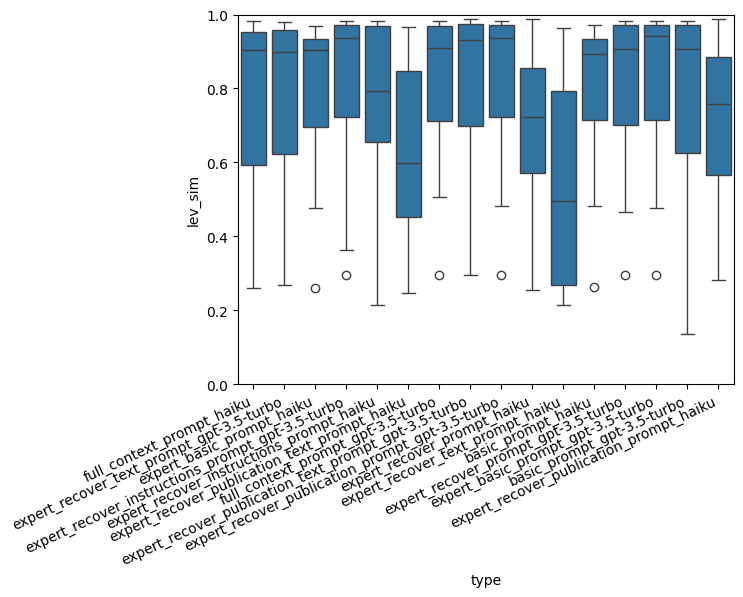

In [7]:
sns.boxplot(data = performance_eval, x = 'type', y = 'lev_sim')
plt.xticks(rotation=25, ha = 'right')  # Rotate labels to 45 degrees
plt.ylim([0, 1.0])
plt.show()

## Conclusions of the prompt test

The test of the prompt design shows that, there are large differences between the performance of gpt3.5 and Haiku. This is unfortunate, as it suggests that each model needs to have it's own prompt identified before you do a full test, unless you want to exhaustively test.

I think that perhaps using the `full_context_prompt` and the `expert_recover_publication_prompt` with both the system message and after content, prompt styles may be the best option. This will require twice as much compute as I was planning to use.

# Create basic and no message responses

Having identified the optimal system message we can now compare the different LLM's. In this experiment it is assumed that the prompt (which is the system message) does not need to be changed but that it may not work as a system message and may need to placed AFTER the text in the prompt message itself.

The below code creates the basic configuration dictionaries for each model and then fills in the with the two different prompt messages creating a single list of all basic prompt/message/model configurations. It then calls all the LLM's and saves the results.
This works in series so takes a while.

In [71]:
#Create the prompt/system message using the best performing from the previous section

system_message = f"""Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. 
Do not add any text, commentary, or lead in sentences  beyond the recovered text. Do not add a title, or any introductions"""

no_prompt = no_message = ""

prompt_content_only = "{content_html}"

prompt_content_message =  "{content_html}"+f""" \n \n """+ system_message

In [ ]:
groq_alt_endpoint = {'alt_endpoint':{'base_url':'https://api.groq.com/openai/v1',
                     'api_key':os.getenv("GROQ_API_KEY")}}

basic_model_configs = pd.DataFrame({
    'get_response_func': [get_response_openai, get_response_openai, get_response_anthropic, get_response_anthropic, 
                          get_response_openai, get_response_openai, get_response_openai], 
    'engine': ['gpt-3.5-turbo', 'gpt-4-turbo-preview', "claude-3-haiku-20240307", "claude-3-opus-20240229", 
               'mixtral-8x7b-32768', 'llama2-70b-4096', 'gemma-7b-it'],
    'additional_args': [
        {}, {}, {}, {}, 
        groq_alt_endpoint, 
        groq_alt_endpoint, 
        groq_alt_endpoint
    ]
})

base_model_configs= []

for index, row in basic_model_configs.iterrows():
    #modify the response name for the type
    row['additional_args']['response_name'] = 'base'
    base_model_configs.append(

        create_config_dict_func(
    get_response_func = row['get_response_func'],
    rate_limiter = RateLimiter(40000),
    engine = row['engine'],
    system_message_template = system_message,
    prompt_template =  prompt_content_only,
    additional_args=row['additional_args']
    )

    )

nosm_model_configs = []

for index, row in basic_model_configs.iterrows():
    #modify the response name for the type
    row['additional_args']['response_name'] = 'nosm' 
    nosm_model_configs.append(

        create_config_dict_func(
    get_response_func = row['get_response_func'],
    rate_limiter = RateLimiter(40000),
    engine = row['engine'],
    system_message_template = no_message,
    prompt_template =  prompt_content_message,
    additional_args=row['additional_args']
    )

    )


model_configs = base_model_configs + nosm_model_configs

compare_request_configurations(dev_data_df, model_configs, folder_path='./data/dev_corrected_base')
    

In [52]:
corrected_folder = './data/dev_corrected_base'

performance_eval =  evaluate_correction_performance_folders(corrected_folder, dev_transcripts, wer, cer)


performance_eval =  performance_eval.loc[(performance_eval['File Name']!='slug_ar02501_periodical_pc_issue_tec_06121884_page_number_25.txt') &
                     (performance_eval['type']!='gpt3_boros_blank_gpt-3.5-turbo'),:]

In [53]:
test = get_metric_error_reduction(performance_eval, raw_dev_ocr_scores)

test.groupby('type').describe().filter(regex = '50|mean').round(2).sort_values(('lev_dist', '50%'))

WER            CER        lev_dist       
                               mean    50%    mean    50%     mean    50%
type                                                                     
nosm_gemma-7b-it              -4.88  -1.72 -199.21 -71.43  -190.16 -55.17
base_mixtral-8x7b-32768      -52.42  35.25 -504.14 -30.20  -472.26 -30.39
base_gemma-7b-it              10.77   3.11 -153.22 -20.00  -145.73 -17.96
nosm_mixtral-8x7b-32768      -22.58  35.48 -365.92  -9.06  -344.00  -7.97
base_llama2-70b-4096           9.77  46.23  -93.55  -1.38   -89.83  -0.44
nosm_llama2-70b-4096          12.31  47.95  -95.59   5.54   -90.03   5.15
base_claude-3-haiku-20240307  48.76  60.53    2.93   9.95     3.06  12.93
nosm_gpt-3.5-turbo            59.56  65.59   43.46  39.45    40.72  38.12
base_gpt-3.5-turbo            53.23  66.98    2.47  45.69     2.05  44.20
nosm_claude-3-haiku-20240307  60.84  72.41   30.83  49.12    30.42  48.50
base_claude-3-opus-20240229   74.06  79.31   54.59  56.99    52.92  57.53
base_gpt-4-turbo-preview      74.04  75.86   59.46  63.72    57.66  64.19
nosm_gpt-4-turbo-preview      72.83  79.31   57.39  65.44    55.36  64.94
nosm_claude-3-opus-20240229   75.59  81.03   59.42  69.33    58.12  67.53

In [3]:
OCR_text = f"""fcm E ¥ gNlGP «® WOTH ) THE R&PP ^ Ol SPBRBTTS . [ The following Letter was written at our request . The writer , a German friend , whose integrity and clear-headedness would command attention to whatever he might assert , informed us of his proposed visit to a house where the Rappitcs were to exhibit , and we begged him to furnish us with a report . We print his letter without any alteration : its statements will , we think , set the reader speculating .Let it be distinctly borne in mind , however , that in printing this Letter we give no countenance whatever to the pretended explanation of " Rapping . " We have our own views of the jugglery by which the "ghosts " are made to communicate with persons willing to pay for the interview , and in a very short time we hope to lay before our readers something like an experimental result . ] My dear Sir , —When I proposed to give you a report on these new prophets , who , if as true as they arc new , open to us a wide and most interesting field for inquiry , overthrow ancient and modem systems of science and belief , shake to the very foundation revealed religion andChristianity , hut , on the other hand , arc telling almost equally strong against Pantheism mid Atheism , I had not seen those prophets , expounders , mediums , or whatever you may call them , myself ; hut what I heard from a friend , a clear-sighted , well-informed , by no moans " gullible , " or over-credulous gentleman , who had paid them ii visit , had made me anxious to see and judge for myself ; and he having determined , for better satisfaction , to have the Medium ( and the spirits ) at his own house , and having kindly invited me to be present on the occasion , 1 offered to furnish you with a statement of the result of the evening , which I now , agreeably to your wish , lay before you .We were five of us in the library , —my friend , his wife , his sister , his nephew , and myself , —when the footman , handing in a card , announced "Mrs . JIayden . " Her entrance and deportment were easy , unembarrassed , and yet not " business-like ; " her exterior rather prepossessing ; an intelligent countenance , with , perhaps , a slight touch of Yankccisin in the corner of the eye ; and the conversation soon bring established , showed that she did not lack those powers of speech so peculiar to the . citizens of the great Republic ; though certain mistakes now and then recurring in the conjugation of verbs , indicated that nhe could not have had a very fin ;! -rate education . We took our seats round the table on which the card had been placed , [ mid , — "Mr . and Mrs . W . R . Jlirydeii , L' 2 , Queen Anne-street , Cavenuish-. squarc . " Expectation created silence , now and then broken by . qiiestions in a low voice , addressed to the Medium , and by the wheels of carriages that brought guests to an evening party at a neighbouring house , and thus tnadd the otherwise very quirt sired ; liither noisy . Tho raps which the Medium and one or two of us , after we had been seated for about ten"""

In [4]:
system_message = f"""Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. 
Do not add any text, commentary, or lead in sentences  beyond the recovered text. Do not add a title, or any introductions"""



prompt = OCR_text + "\n\n" + f"""Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. Do not add any text, commentary, or lead in sentences  beyond the recovered text"""

#system_message = ""

#prompt = OCR_text

In [6]:
configurations = [create_config_dict_func(
    get_response_func = get_response_anthropic,
    rate_limiter = RateLimiter(40000),
    engine = "claude-3-haiku-20240307",
    system_message_template = "",
    prompt_template =  "{content_html}"+f""" \n \n """+ system_message,
    additional_args={'response_name':'haiku_nosm_base'}
),

create_config_dict_func(
    get_response_func = get_response_anthropic,
    rate_limiter = RateLimiter(40000),
    engine = "claude-3-opus-20240229",
    system_message_template = system_message,
    prompt_template =  "{content_html}",
    additional_args={'response_name':'opus_base'}
)]





In [8]:
use_df_to_call_llm_api(config_dict, dev_data_raw_df, 'haiku_base' , folder_path='./data/dev_corrected')

/home/jonno/redigitalize/llm_caller.py:237: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  times_df = pd.concat([times_df, pd.DataFrame([new_records], index = [0])], ignore_index=True)


In [ ]:
rate_limiter = RateLimiter(50000)

test = get_response_anthropic(prompt, system_message, rate_limiter, engine="claude-3-haiku-20240307", max_tokens = 4000)

In [ ]:
message

Message(id='msg_01RDuf2hzxmMSCQHRQkQT9XH', content=[ContentBlock(text='Here is the text recovered from the corrupted OCR, with appropriate paragraph breaks:\n\nMy dear Sir, —When I proposed to give you a report on these new prophets, who, if as true as they are new, open to us a wide and most interesting field for inquiry, overthrow ancient and modern systems of science and belief, shake to the very foundation revealed religion and Christianity, but, on the other hand, are telling almost equally strong against Pantheism and Atheism, I had not seen those prophets, expounders, mediums, or whatever you may call them, myself; but what I heard from a friend, a clear-sighted, well-informed, by no means "gullible," or over-credulous gentleman, who had paid them a visit, had made me anxious to see and judge for myself; and he having determined, for better satisfaction, to have the Medium (and the spirits) at his own house, and having kindly invited me to be present on the occasion, I offered t

fcm E ¥ gNlGP «® WOTH ) THE R&PP ^ Ol SPBRBTTS . [ The following Letter was written at our request . The writer , a German friend , whose integrity and clear-headedness would command attention to whatever he might assert , informed us of his proposed visit to a house where the Rappitcs were to exhibit , and we begged him to furnish us with a report . We print his letter without any alteration : its statements will , we think , set the reader speculating .Let it be distinctly borne in mind , however , that in printing this Letter we give no countenance whatever to the pretended explanation of " Rapping . " We have our own views of the jugglery by which the "ghosts " are made to communicate with persons willing to pay for the interview , and in a very short time we hope to lay before our readers something like an experimental result . ] My dear Sir , —When I proposed to give you a report on these new prophets , who , if as true as they arc new , open to us a wide and most interesting field for inquiry , overthrow ancient and modem systems of science and belief , shake to the very foundation revealed religion andChristianity , hut , on the other hand , arc telling almost equally strong against Pantheism mid Atheism , I had not seen those prophets , expounders , mediums , or whatever you may call them , myself ; hut what I heard from a friend , a clear-sighted , well-informed , by no moans " gullible , " or over-credulous gentleman , who had paid them ii visit , had made me anxious to see and judge for myself ; and he having determined , for better satisfaction , to have the Medium ( and the spirits ) at his own house , and having kindly invited me to be present on the occasion , 1 offered to furnish you with a statement of the result of the evening , which I now , agreeably to your wish , lay before you .We were five of us in the library , —my friend , his wife , his sister , his nephew , and myself , —when the footman , handing in a card , announced "Mrs . JIayden . " Her entrance and deportment were easy , unembarrassed , and yet not " business-like ; " her exterior rather prepossessing ; an intelligent countenance , with , perhaps , a slight touch of Yankccisin in the corner of the eye ; and the conversation soon bring established , showed that she did not lack those powers of speech so peculiar to the . citizens of the great Republic ; though certain mistakes now and then recurring in the conjugation of verbs , indicated that nhe could not have had a very fin ;! -rate education . We took our seats round the table on which the card had been placed , [ mid , — "Mr . and Mrs . W . R . Jlirydeii , L' 2 , Queen Anne-street , Cavenuish-. squarc . " Expectation created silence , now and then broken by . qiiestions in a low voice , addressed to the Medium , and by the wheels of carriages that brought guests to an evening party at a neighbouring house , and thus tnadd the otherwise very quirt sired ; liither noisy . Tho raps which the Medium and one or two of us , after we had been seated for about ten

Please recover the text from the corrupted OCR, providing appropriate paragraph breaks. Do not add any text, commentary, or lead in sentences  beyond the recovered text, for example for the text

"Md BRO5n0n D1e] t@ ay"

The correct response would be

"Mr Bronson Died today"

An incorrect response would be 

"Sure here is the recovered text: Mr Bronson died today"

Another incorrect response would be

"Here is the recovered text from the corrupted OCR: Mr Bronson died today"

In both cases a lead in sentence was generated which is why the example responses were incorrect

